In [1]:
from pathlib import Path, PurePath
import pandas as pd
import matplotlib.pyplot as plt
import os
import obspy
from obspy.geodetics.base import gps2dist_azimuth
from preprocessing_tools import *

1 día de datos, primeros 4 dígitos estación, y luego el canal después del punto. Hay un evento significativo de magnitud mayor a 5 que puede usarse como referencia para probar la buena implementación del método de John Ebel y Nawa Dahal.

El archivo catalog.dat sirve para especificar los eventos sísmicos significativos que fueron detectados en el conjunto grande de datos y sus columnas son: fecha, hora, latitud, longitud, profundidad, magnitud y lasa ultimas tres columnas son datos independientes relacionados con la similitud o correlación entre dichos eventos. A partir de este archivo, es posible localizar y filtrar los datos completos para incluir únicamente la sección en que se percibieron estos eventos para tratar menos datos. Posibilidad de paralelizar en caso de que se requiera.

Una vez hecho esto, ya toca implementar el método de John Ebel y Nawa Dahal en cuestión

In [2]:
directorio_completo = r'Datos/'
directorio_recortado = r'Datos_Trim/'
if not os.path.exists(directorio_recortado):
    os.makedirs(directorio_recortado)

In [3]:
catalog = 'catalog.dat'

In [4]:
df_catalog = read_catalog(catalog)

In [5]:
df_catalog.head()

,date_time,lat,lon,depth,mag,corr
0,2018-08-12T01:17:47.060000Z,17.180,-100.950,3.1,1.20,"[0.7309, 37.06, 20180812011747.06]"
1,2018-08-12T01:37:43.000000Z,17.180,-101.020,26.9,3.90,"[1.0, 52.15, 20180812013743.0]"
2,2018-08-12T02:06:47.640000Z,17.235,-101.435,26.0,2.41,"[0.5361, 22.24, 20180605040434.0]"
3,2018-08-12T02:21:18.100000Z,17.030,-100.900,69.7,2.25,"[0.5164, 21.02, 20180810013340.0]"
4,2018-08-12T05:13:06.000000Z,16.490,-100.580,6.4,4.30,"[0.9795, 46.39, 20180812051306.0]"


In [6]:
df_sort = df_catalog.sort_values('mag', ascending=False).copy()

In [7]:
df_sort.head()

,date_time,lat,lon,depth,mag,corr
8,2018-08-12T14:42:09.000000Z,17.110,-100.840,44.3,5.20,"[0.9316, 51.61, 20180812144209.0]"
4,2018-08-12T05:13:06.000000Z,16.490,-100.580,6.4,4.30,"[0.9795, 46.39, 20180812051306.0]"
1,2018-08-12T01:37:43.000000Z,17.180,-101.020,26.9,3.90,"[1.0, 52.15, 20180812013743.0]"
6,2018-08-12T11:45:10.000000Z,16.950,-100.380,31.9,3.60,"[0.9133, 45.26, 20180812114510.0]"
2,2018-08-12T02:06:47.640000Z,17.235,-101.435,26.0,2.41,"[0.5361, 22.24, 20180605040434.0]"


In [8]:
t0 = df_sort['date_time'][0] # tiempo de sismo mas fuerte registrado
tf = t0 + 60
print(t0)

2018-08-12T01:17:47.060000Z


In [9]:
stations_meta = get_meta_data(directorio_completo)

In [10]:
stations_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 35 columns):
b           21 non-null float64
cmpaz       21 non-null float64
cmpinc      21 non-null float64
delta       21 non-null float64
depmax      21 non-null float64
depmen      3 non-null float64
depmin      21 non-null float64
e           21 non-null float64
iftype      21 non-null int64
kcmpnm      21 non-null object
kevnm       21 non-null object
kstnm       21 non-null object
kuser0      21 non-null object
lcalda      21 non-null int64
leven       21 non-null int64
lovrok      21 non-null int64
lpspol      21 non-null int64
nevid       21 non-null int64
norid       21 non-null int64
npts        21 non-null int64
nvhdr       21 non-null int64
nzhour      21 non-null int64
nzjday      21 non-null int64
nzmin       21 non-null int64
nzmsec      21 non-null int64
nzsec       21 non-null int64
nzyear      21 non-null int64
resp0       21 non-null float64
resp1       21 non-null float64
resp

In [11]:
stations_meta['kstnm']

0     1S01
1     1S01
2     1S01
3     1S03
4     1S03
5     1S03
6     1S04
7     1S04
8     1S04
9     1S05
10    1S05
11    1S05
12    1S07
13    1S07
14    1S07
15    1S08
16    1S08
17    1S08
18    1S09
19    1S09
20    1S09
Name: kstnm, dtype: object

In [12]:
stations_meta.head(30) # stel dejar tal cual o a 0
# No unir en grupos las filas ya que las primeras columnas son de orientacion de los sensores de cada canal, lo cual es importante
# Crear repositorio github

,b,cmpaz,cmpinc,delta,depmax,depmen,depmin,e,iftype,kcmpnm,...,nzsec,nzyear,resp0,resp1,resp2,resp3,stel,stla,stlo,unused23
0,0.0,90.0,90.0,0.005,1.712276e-03,0.000001,-1.712279e-03,86400.0,1,E,...,0,2018,3.265913e-09,20.0,1.0,0.7,-2386.0,16.683641,-100.741394,0
1,0.0,0.0,90.0,0.005,1.712276e-03,0.000001,-1.712279e-03,86400.0,1,N,...,0,2018,3.265913e-09,20.0,1.0,0.7,-2386.0,16.683641,-100.741394,0
2,0.0,0.0,0.0,0.005,1.344283e-03,0.000002,-9.943596e-04,86400.0,1,U,...,0,2018,3.265913e-09,20.0,1.0,0.7,-2386.0,16.683641,-100.741394,0
3,0.0,90.0,90.0,0.005,3.318486e+38,NaN,-3.358415e+38,86400.0,1,E,...,0,2018,3.265913e-09,20.0,1.0,0.7,-984.0,16.797607,-100.459198,0
4,0.0,0.0,90.0,0.005,3.343357e+38,NaN,-3.379704e+38,86400.0,1,N,...,0,2018,3.265913e-09,20.0,1.0,0.7,-984.0,16.797607,-100.459198,0
5,0.0,0.0,0.0,0.005,3.391023e+38,NaN,-3.383286e+38,86400.0,1,U,...,0,2018,3.265913e-09,20.0,1.0,0.7,-984.0,16.797607,-100.459198,0
6,0.0,90.0,90.0,0.005,3.346421e+38,NaN,-3.365736e+38,86400.0,1,E,...,0,2018,3.265913e-09,20.0,1.0,0.7,-1388.0,16.923592,-100.757507,0
7,0.0,0.0,90.0,0.005,3.339749e+38,NaN,-3.358415e+38,86400.0,1,N,...,0,2018,3.265913e-09,20.0,1.0,0.7,-1388.0,16.923592,-100.757507,0
8,0.0,0.0,0.0,0.005,3.343357e+38,NaN,-3.400317e+38,86400.0,1,U,...,0,2018,3.265913e-09,20.0,1.0,0.7,-1388.0,16.923592,-100.757507,0
9,0.0,90.0,90.0,0.005,3.343331e+38,NaN,-3.386350e+38,86400.0,1,E,...,0,2018,3.265913e-09,20.0,1.0,0.7,-2347.0,16.801371,-100.998512,0


In [13]:
stations_meta.loc[stations_meta['kstnm'] == '1S01']

,b,cmpaz,cmpinc,delta,depmax,depmen,depmin,e,iftype,kcmpnm,...,nzsec,nzyear,resp0,resp1,resp2,resp3,stel,stla,stlo,unused23
0,0.0,90.0,90.0,0.005,0.001712,0.000001,-0.001712,86400.0,1,E,...,0,2018,3.265913e-09,20.0,1.0,0.7,-2386.0,16.683641,-100.741394,0
1,0.0,0.0,90.0,0.005,0.001712,0.000001,-0.001712,86400.0,1,N,...,0,2018,3.265913e-09,20.0,1.0,0.7,-2386.0,16.683641,-100.741394,0
2,0.0,0.0,0.0,0.005,0.001344,0.000002,-0.000994,86400.0,1,U,...,0,2018,3.265913e-09,20.0,1.0,0.7,-2386.0,16.683641,-100.741394,0


In [14]:
Trim_Org(directorio_recortado, directorio_completo, 60, df_catalog, stations_meta)

No hay que hacer group by ya que cada canal de cada estacion tiene ciertas alineaciones o angulos distintos

Descuidar de altitudes negativas, estblecer en 0 si se da error

In [15]:
stations_meta[['kstnm', 'kcmpnm']].head(20)

,kstnm,kcmpnm
0,1S01,E
1,1S01,N
2,1S01,U
3,1S03,E
4,1S03,N
5,1S03,U
6,1S04,E
7,1S04,N
8,1S04,U
9,1S05,E


In [16]:
ev_df, st_df, ev_st_df = get_tr_meta(directorio_recortado)

In [17]:
ev_df.head(20)

,starttime,endtime,sampling_rate,id
0,2018-08-12T13:21:54.398438Z,2018-08-12T13:22:54.398438Z,200.0,0
1,2018-08-12T18:27:37.078125Z,2018-08-12T18:28:37.078125Z,200.0,1
2,2018-08-12T16:42:35.761719Z,2018-08-12T16:43:35.761719Z,200.0,2
3,2018-08-12T05:13:06.000000Z,2018-08-12T05:14:06.000000Z,200.0,3
4,2018-08-12T15:23:31.339844Z,2018-08-12T15:24:31.339844Z,200.0,4
5,2018-08-12T15:06:37.941406Z,2018-08-12T15:07:37.941406Z,200.0,5
6,2018-08-12T01:37:43.000000Z,2018-08-12T01:38:43.000000Z,200.0,6
7,2018-08-12T06:23:37.380859Z,2018-08-12T06:24:37.380859Z,200.0,7
8,2018-08-12T15:54:22.121094Z,2018-08-12T15:55:22.121094Z,200.0,8
9,2018-08-12T01:17:47.060059Z,2018-08-12T01:18:47.060059Z,200.0,9


In [18]:
st_df.head(20)

,station_channel,id
0,1S01_E,0
1,1S01_N,1
2,1S01_U,2
3,1S03_E,3
4,1S03_N,4
5,1S03_U,5
6,1S04_E,6
7,1S04_N,7
8,1S04_U,8
9,1S05_E,9


In [19]:
ev_st_df.head()

,ev_id,st_id
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


In [20]:
df_catalog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
date_time    14 non-null object
lat          14 non-null float64
lon          14 non-null float64
depth        14 non-null float64
mag          14 non-null float64
corr         14 non-null object
dtypes: float64(4), object(2)
memory usage: 800.0+ bytes


In [21]:
stations_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 35 columns):
b           21 non-null float64
cmpaz       21 non-null float64
cmpinc      21 non-null float64
delta       21 non-null float64
depmax      21 non-null float64
depmen      3 non-null float64
depmin      21 non-null float64
e           21 non-null float64
iftype      21 non-null int64
kcmpnm      21 non-null object
kevnm       21 non-null object
kstnm       21 non-null object
kuser0      21 non-null object
lcalda      21 non-null int64
leven       21 non-null int64
lovrok      21 non-null int64
lpspol      21 non-null int64
nevid       21 non-null int64
norid       21 non-null int64
npts        21 non-null int64
nvhdr       21 non-null int64
nzhour      21 non-null int64
nzjday      21 non-null int64
nzmin       21 non-null int64
nzmsec      21 non-null int64
nzsec       21 non-null int64
nzyear      21 non-null int64
resp0       21 non-null float64
resp1       21 non-null float64
resp

In [22]:
#stations_meta.loc[stations_meta['kstnm'] == '1S01'].iloc[1]

In [23]:
#A = obspy.read('Datos_Trim/*')

#A.plot()
#plt.show()

En desarrollo...

In [24]:
distances = []
azimuths = []
b_azimuths = []
for index,row in df_catalog.iterrows(): # Para todo evento
    event_dir = directorio_recortado + datetime_to_dotformat(row.date_time)+'/'
    outdir = "%sRT"%event_dir # Output directory
    
    st = obspy.read(event_dir+'*', format='SAC')
    Path(outdir).mkdir(parents=True,exist_ok=True)
    
    # Detrend and remove instrument response
    st.detrend(type="linear") # equivalent to rtr in SAC
    st.detrend(type="linear")
    st.detrend(type="demean") # remove mean

    # Define SAC headers and calculate back-azimtuh for rotation
    origin_time = row.date_time
    depth = row.depth*1000

    #o = []
    #b = []
    for i, sta in stations_meta.iterrows(): # Para todo evento y para toda estacion
        #meta = inv.get_channel_metadata(tr.id)
        dist, az, baz = gps2dist_azimuth(row.lat,row.lon,sta.stla,sta.stlo)
        #omarker = origin_time - tr.starttime
        
        # Para propositos de este problema, se podra asumir que el tiempo del evento y el tiempo de inicio del sismograma son el mismo?
        
        # baz (back azimuth) es aquel angulo de la estacion con las coordenadas del sismo o evento, asi que lo tendremos que guardar en el trace 

        # Obspy trace headers
        #tr.stats.coordinates = {'latitude':meta['latitude'], 'longitude':meta['longitude']}
        distances.append(dist/1000) # A kilometros
        azimuths.append(az)
        b_azimuths.append(baz)
        #o.append(0)
        #b.append(-1*omarker)
        
        # Modificando valores en los traces (puede que haya que reemplazar los archivos o volver a guardarlos para que sean efectivos los cambios)
        st[i].stats.az = az
        st[i].stats.back_azimuth = baz
        st[i].stats.distance = dist/1000
        #st[i].stats.sac.o = 0
        #st[i].stats.sac.b = -1*omarker
        
    #for sta in stations_meta['kstnm'].unique():
    #    traces = st.select(station=sta)
    #    traces.rotate(method="NE->RT")
    
    # No es necesario rotar a ZNE en el caso de los datos de la red subarina ya que los tres componentes o canales ya vienen orientados en norte, este y la vertical

    # Todas las estaciones submarinas ya vienen con tres componentes, asi que tampoco es necesario verificarlo
    # Se rota a RT para trabajar mas facilmente la distancia y el angulo con cada sismo
    st.rotate(method="NE->RT")
    
    for tr in st:
        tr.write("%s/%s"%(outdir,tr.id),format="SAC")
    
ev_st_df['distance'] = distances
ev_st_df['azimuth'] = azimuths
ev_st_df['b_azimuth'] = b_azimuths
#tr_df['o'] = o
#tr_df['b'] = b

In [25]:
ev_st_df.head(10)

,ev_id,st_id,distance,azimuth,b_azimuth
0,0,0,59.255715,157.944508,338.005261
1,0,1,59.255715,157.944508,338.005261
2,0,2,59.255715,157.944508,338.005261
3,0,3,67.250886,128.924385,309.067792
4,0,4,67.250886,128.924385,309.067792
5,0,5,67.250886,128.924385,309.067792
6,0,6,35.002297,144.136940,324.193386
7,0,7,35.002297,144.136940,324.193386
8,0,8,35.002297,144.136940,324.193386
9,0,9,42.219855,187.035566,7.021390


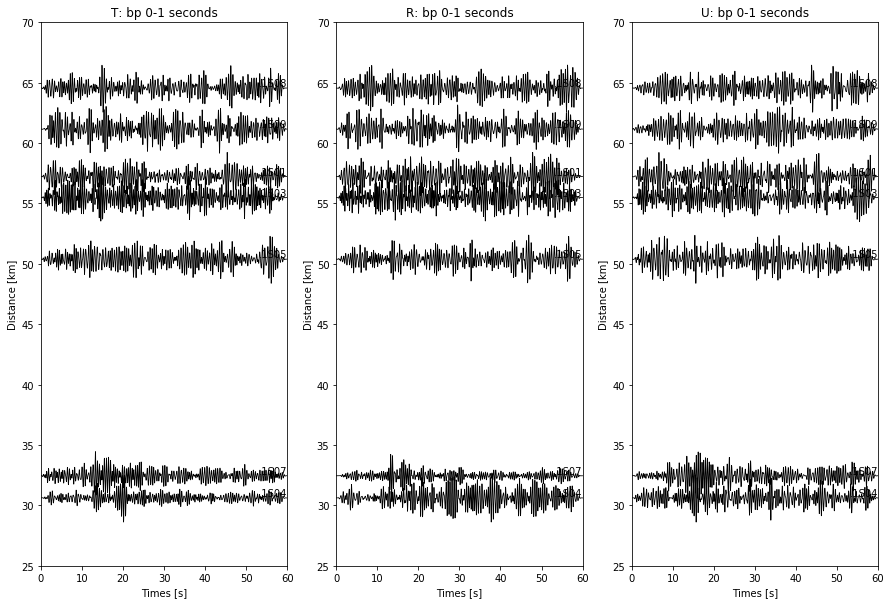

In [37]:
# Rango de frecuencias establecido por Dahal y Ebel
freqmin = 1.5
freqmax = 2.5
corners = 2
st_filt = st.copy()

st_filt.filter("bandpass",freqmin=freqmin,freqmax=freqmax,corners=corners,zerophase=True)
st_filt.taper(max_percentage=0.05)

xmin = 0
xmax = 60 # El tiempo de grabacion
ymin = 25
ymax = 70
scale = 2
fig, axes = plt.subplots(1,3,figsize=(15,10))
for component, ax in zip(("T","R","U"),axes):
    for tr in st_filt.select(component=component):
        times = tr.times() - (origin_time - tr.stats.starttime)
        tr.data /= max(abs(tr.data))
        tr.data *= scale
        ax.plot(times,tr.data+tr.stats.distance,color="black",linewidth=0.8)
        ax.text(xmax,tr.stats.distance,"%s.%s"%(tr.stats.network,tr.stats.station),va="bottom",ha="right")
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel("Times [s]")
    ax.set_ylabel("Distance [km]")
    ax.set_title("%s: bp %.0f-%.0f seconds"%(component,1/freqmax,1/freqmin))